In [1]:
# Install PyTorch
!pip install https://download.pytorch.org/whl/cpu/torch-1.0.1.post2-cp36-cp36m-linux_x86_64.whl
!pip install torchvision

# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

print("Libraries imported - ready to use PyTorch", torch.__version__)

    100% |████████████████████████████████| 67.1MB 372kB/s ta 0:00:011  2% |▉                               | 1.8MB 52.0MB/s eta 0:00:02    3% |█▏                              | 2.4MB 25.5MB/s eta 0:00:03    4% |█▍                              | 2.8MB 3.6MB/s eta 0:00:19    15% |████▉                           | 10.1MB 16.0MB/s eta 0:00:04    17% |█████▌                          | 11.6MB 20.7MB/s eta 0:00:03    18% |█████▉                          | 12.2MB 9.5MB/s eta 0:00:06    19% |██████                          | 12.8MB 14.3MB/s eta 0:00:04    22% |███████▍                        | 15.4MB 8.4MB/s eta 0:00:07    25% |████████                        | 17.0MB 10.0MB/s eta 0:00:05    29% |█████████▍                      | 19.7MB 17.5MB/s eta 0:00:03    30% |██████████                      | 20.7MB 4.7MB/s eta 0:00:10    34% |███████████                     | 23.0MB 7.3MB/s eta 0:00:06    37% |████████████                    | 25.0MB 7.2MB/s eta 0:00:06    53% |█████████████████        

### Load Data

In [3]:
# Function to ingest data using training and test loaders
def load_dataset(data_path):
    # Load all of the images
    transformation = transforms.Compose([
        # Randomly augment the image data
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(180),
        # transform to tensors
        transforms.ToTensor(),
        # Normalize the pixel values (in R, G, and B channels)
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Load all of the images, transforming them
    full_dataset = torchvision.datasets.ImageFolder(
        root=data_path,
        transform=transformation
    )
    
    
    # Split into training (70% and testing (30%) datasets)
    train_size = int(0.7 * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
    # define a loader for the training data we can iterate through in 50-image batches
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=images_per_batch,
        num_workers=1,
        shuffle=False
    )
    
    # define a loader for the testing data we can iterate through in 50-image batches
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=images_per_batch,
        num_workers=1,
        shuffle=False
    )
        
    return train_loader, test_loader

import os

train_folder = "../data/classification/training"
img_size = (128,128)
images_per_batch = 18

# Get the class names
classes = os.listdir(train_folder)
classes.sort()
print(classes)

# Get the iterative dataloaders for test and training data
train_loader, test_loader = load_dataset(train_folder)

['automobile', 'plane', 'train']


### Define a Neural Network Model

In [4]:
# Create a neural net class
class Net(nn.Module):
    # Constructor
    def __init__(self, num_classes=3):
        super(Net, self).__init__()
        
        # Our images are RGB, so input channels = 3. We'll apply 24 filters in the first convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # A second convolutional layer takes 24 input channels, and generates 24 outputs
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, stride=1, padding=1)
        
        # A second convolutional layer takes 24 input channels, and generates 48 outputs
        self.conv3 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3, stride=1, padding=1)
        
        # We'll apply max pooling with a kernel size of 2
        self.pool = nn.MaxPool2d(kernel_size=2)
        
        # A drop layer deletes 50% of the features to help prevent overfitting
        self.drop = nn.Dropout2d(p=0.5)
        
        # Our 128x128 image tensors will be pooled three times with a kernel size of 2. 128/2/2/2 is 16.
        # So our feature tensors are now 32 x 32, and we've generated 48 of them so our array is 16x16x48
        # We need to flatten these and feed them to a fully-connected layer
        # to map them to  the probability for each class
        self.fc = nn.Linear(in_features=16 * 16 * 48, out_features=num_classes)

    def forward(self, x):
        # Use a relu activation function after convolution 1 and pool
        x = F.relu(self.pool(self.conv1(x)))
      
        # Use a relu activation function after convolution 2 and pool
        x = F.relu(self.pool(self.conv2(x)))
        
        # Use a relu activation function after convolution 2)
        x = F.relu(self.conv2(x))
        
        # Use a relu activation function after convolution 2
        x = F.relu(self.conv2(x))
        
         # Use a relu activation function after convolution 3 and pool
        x = F.relu(self.pool(self.conv3(x)))
        
        # Select some features to drop to prevent overfitting (only drop during training)
        x = F.dropout(self.drop(x), training=self.training)
        
        # Flatten
        x = x.view(-1, 16 * 16 * 48)
        # Feed to fully-connected layer to predict class
        x = self.fc(x)
        # Return class probabilities via a log_softmax function 
        return F.log_softmax(x, dim=1)
    
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda (on a cpu, training will take a considerable length of time!)
    device = "cuda"

# Create an instance of the model class and allocate it to the device
model = Net(num_classes=len(classes)).to(device)

print(model)

Net(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.5)
  (fc): Linear(in_features=12288, out_features=3, bias=True)
)


### Train the Model

In [5]:
def train(model, device, train_loader, optimizer, epoch):
    # Set the model to training mode
    model.train()
    train_loss = 0
    print("Epoch:", epoch)
    # Process the images in batches
    for batch_idx, (data, target) in enumerate(train_loader):
        # Use the CPU or GPU as appropriate
        data, target = data.to(device), target.to(device)
        
        # Reset the optimizer
        optimizer.zero_grad()
        
        # Push the data forward through the model layers
        output = model(data)
        
        # Get the loss
        loss = loss_criteria(output, target)

        # Keep a running total
        train_loss += loss.item()
        
        # Backpropagate
        loss.backward()
        optimizer.step()
        
        # Print metrics so we see some progress
        print('\tTraining batch {} Loss: {:.6f}'.format(batch_idx + 1, loss.item()))
            
    # return average loss for the epoch
    avg_loss = train_loss / (batch_idx+1)
    print('Training set: Average loss: {:.6f}'.format(avg_loss))
    return avg_loss
            
            
def test(model, device, test_loader):
    # Switch the model to evaluation mode (so we don't backpropagate or drop)
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            
            # Get the predicted classes for this batch
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    # Calculate the average loss and total accuracy for this epoch
    avg_loss = test_loss/batch_count
    print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # return average loss for the epoch
    return avg_loss
    
    
# Use an "Adam" optimizer to adjust weights
# (see https://pytorch.org/docs/stable/optim.html#algorithms for details of supported algorithms)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Specify the loss criteria
loss_criteria = nn.CrossEntropyLoss()

# Track metrics in these arrays
epoch_nums = []
training_loss = []
validation_loss = []

# Train over 30 epochs
epochs = 30
print('Training on', device)
for epoch in range(1, epochs + 1):
        train_loss = train(model, device, train_loader, optimizer, epoch)
        test_loss = test(model, device, test_loader)
        epoch_nums.append(epoch)
        training_loss.append(train_loss)
        validation_loss.append(test_loss)

Training on cpu
Epoch: 1
	Training batch 1 Loss: 1.096138
	Training batch 2 Loss: 1.085530
	Training batch 3 Loss: 1.068862
	Training batch 4 Loss: 1.131336
	Training batch 5 Loss: 1.107659
	Training batch 6 Loss: 1.089919
	Training batch 7 Loss: 1.070877
	Training batch 8 Loss: 1.056841
	Training batch 9 Loss: 1.106916
	Training batch 10 Loss: 1.164254
Training set: Average loss: 1.097833
Validation set: Average loss: 1.1061, Accuracy: 21/72 (29%)

Epoch: 2
	Training batch 1 Loss: 1.211090
	Training batch 2 Loss: 1.053747
	Training batch 3 Loss: 1.069154
	Training batch 4 Loss: 1.143746
	Training batch 5 Loss: 1.159120
	Training batch 6 Loss: 1.073345
	Training batch 7 Loss: 1.108624
	Training batch 8 Loss: 1.164235
	Training batch 9 Loss: 1.057855
	Training batch 10 Loss: 1.077980
Training set: Average loss: 1.111890
Validation set: Average loss: 1.0874, Accuracy: 19/72 (26%)

Epoch: 3
	Training batch 1 Loss: 1.043187
	Training batch 2 Loss: 1.059749
	Training batch 3 Loss: 1.074270


	Training batch 10 Loss: 1.131597
Training set: Average loss: 0.833661
Validation set: Average loss: 0.7809, Accuracy: 52/72 (72%)

Epoch: 20
	Training batch 1 Loss: 0.677533
	Training batch 2 Loss: 0.798858
	Training batch 3 Loss: 0.712248
	Training batch 4 Loss: 0.705984
	Training batch 5 Loss: 1.050716
	Training batch 6 Loss: 0.659933
	Training batch 7 Loss: 0.718641
	Training batch 8 Loss: 0.764144
	Training batch 9 Loss: 0.754965
	Training batch 10 Loss: 1.050524
Training set: Average loss: 0.789354
Validation set: Average loss: 0.7197, Accuracy: 51/72 (71%)

Epoch: 21
	Training batch 1 Loss: 0.600505
	Training batch 2 Loss: 0.705101
	Training batch 3 Loss: 0.648712
	Training batch 4 Loss: 0.585842
	Training batch 5 Loss: 1.046413
	Training batch 6 Loss: 0.805451
	Training batch 7 Loss: 0.741250
	Training batch 8 Loss: 0.804658
	Training batch 9 Loss: 0.918494
	Training batch 10 Loss: 0.557682
Training set: Average loss: 0.741411
Validation set: Average loss: 0.7980, Accuracy: 49/

### View the Loss History

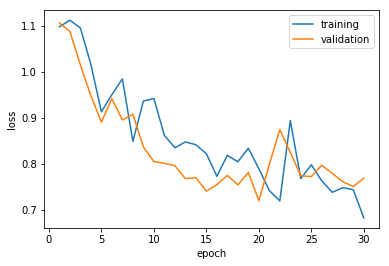

In [6]:
from matplotlib import pyplot as plt
%matplotlib inline


plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

Getting predictions from test set...


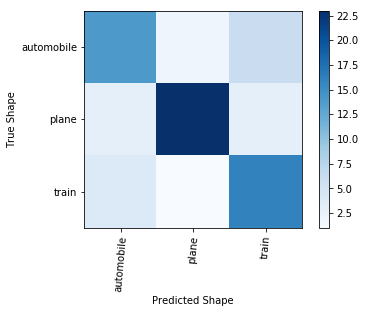

In [7]:
#Pytorch doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import numpy as np

truelabels = []
predictions = []
model.eval()
print("Getting predictions from test set...")
for data, target in test_loader:
    for label in target.data.numpy():
        truelabels.append(label)
    for prediction in model(data).data.numpy().argmax(1):
        predictions.append(prediction) 

# Plot the confusion matrix
cm = confusion_matrix(truelabels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=85)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Shape")
plt.ylabel("True Shape")
plt.show()

### Save the Model

In [8]:
# Save the model weights
model_file = 'vehicle-classifier.pt'
torch.save(model.state_dict(), model_file)
print("Model saved.")

# Delete the existing model variable
del model

Model saved.


### Use the Model with New Data

In [9]:
# Helper function to resize image
def resize_image(src_img, size=(128,128), bg_color="white"): 
    from PIL import Image

    # rescale the image so the longest edge is the right size
    src_img.thumbnail(size, Image.ANTIALIAS)
    
    # Create a new image of the right shape
    new_image = Image.new("RGB", size, bg_color)
    
    # Paste the rescaled image onto the new background
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))
  
    # return the resized image
    return new_image

# Function to predict the class of an image
def predict_image(classifier, image_array):
   
    # Set the classifer model to evaluation mode
    classifier.eval()
    
    # These are the classes our model can predict
    class_names = ['automobile', 'plane', 'train']
    
    # Apply the same transformations as we did for the training images
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Preprocess the imagees
    image_tensor = torch.stack([transformation(image).float() for image in image_array])

    # Turn the input into a Variable
    input_features = image_tensor

    # Predict the class of each input image
    predictions = classifier(input_features)
    
    predicted_classes = []
    # Convert the predictions to a numpy array 
    for prediction in predictions.data.numpy():
        # The prediction for each image is the probability for each class, e.g. [0.8, 0.1, 0.2]
        # So get the index of the highest probability
        class_idx = np.argmax(prediction)
        # And append the corresponding class name to the results
        predicted_classes.append(class_names[class_idx])
    return np.array(predicted_classes)

print("Functions created - ready to use model for inference.")

Functions created - ready to use model for inference.


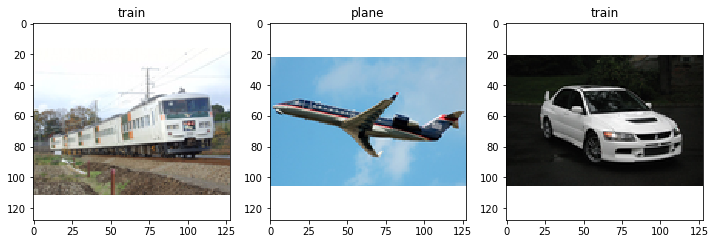

In [10]:
import os
from random import randint
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

# load the saved model weights
model = Net(num_classes=3)
model.load_state_dict(torch.load(model_file))


#get the list of test image files
test_folder = '../data/classification/test'
test_image_files = os.listdir(test_folder)

# Empty array on which to store the images
image_arrays = []

size = (128,128)
background_color = "white"

fig = plt.figure(figsize=(12, 8))

# Get the images and show the predicted classes
for file_idx in range(len(test_image_files)):
    img = Image.open(os.path.join(test_folder, test_image_files[file_idx]))
    
    # resize the image so it matches the training set - it  must be the same size as the images on which the model was trained
    resized_img = np.array(resize_image(img, size, background_color))
                      
    # Add the image to the array of images
    image_arrays.append(resized_img)

# Get predictions from the array of image arrays
# Note that the model expects an array of 1 or more images - just like the batches on which it was trained
predictions = predict_image(model, np.array(image_arrays))

# plot easch image with its corresponding prediction
for idx in range(len(predictions)):
    a=fig.add_subplot(1,len(predictions),idx+1)
    imgplot = plt.imshow(image_arrays[idx])
    a.set_title(predictions[idx])
